In [19]:
import cobra
import pandas as pd
import os
from os.path import join
from cobra import Model, Reaction, Metabolite
from cobra.sampling import sampling
import numpy as np
os.environ["R_HOME"] = f"{os.environ['CONDA_PREFIX']}\\Lib\\R"
import rpy2.robjects
from plotnine import *
import matplotlib.pyplot as plt 


In [20]:
# Importing the model
model1=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880_jsb.xml")


In [21]:
# biomass_rxn = model1.reactions.get_by_id("BIOMASS_RT")
# ngam_rxn = model1.reactions.get_by_id("ATPM")


In [22]:
# ## Saving json model
# from cobra.io import save_json_model
# save_json_model(model, f"C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880_jsb_model.json")

In [23]:
# Lab data
glucose_uptakes= [0.476, 1.114, 1.648, 2.305, 3.1]
growth_rates = [0.03396, 0.082468, 0.123068, 0.17302, 0.233464]   
#  calculated when optimized for biomass max when constrained to lab glucose data
model1.objective =  "ATPM"# 

solution1 = model1.optimize('minimize')
# All fluxes
all_fluxes = solution1.fluxes.to_frame(name='Flux')


In [24]:
# # Get all fluxes to excel
# with pd.ExcelWriter('C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\Rt_IFO0880_jsb_results\\ppp_fluxes_dif_glc_uptakes.xlsx') as excel_writer:
#     all_fluxes.to_excel(excel_writer, sheet_name='Glucose uptake range 0.49-3.1', index=True)

In [25]:
# Get all fluxes on different glucose uptake
all_fluxes_NGAM_min = pd.DataFrame(columns=[ 'Growth rate','Glucose uptake', *all_fluxes.index], index=range(len(glucose_uptakes))) #flux_values.index gives the row names column, * extracts the list of strings

for i in range(len(glucose_uptakes)):

    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880_jsb.xml")
    model.objective =  "ATPM"# 
    model.reactions.EX_glc__D_e.bounds = -(glucose_uptakes[i]), -(glucose_uptakes[i])
    model.reactions.BIOMASS_RT.bounds = growth_rates[i], growth_rates[i]
    # ngam_rxn.objective_coefficient = -1
    # biomass_rxn.objective_coefficient = 1
    solution = model.optimize('minimize' ) # 
    all_fluxes_NGAM_min.loc[i] = solution.fluxes[[ 'BIOMASS_RT','EX_glc__D_e', *all_fluxes.index]].values

all_fluxes_NGAM_min


,Growth rate,Glucose uptake,ALCD25yi,MTHFCm,AMPN,DAGCPTer_RT,PYRt2,NNDPRm,HMGCOASm,PDE4,...,BTNt2i,EX_fol_e,FOLt,NADtm,EX_pydxn_e,PYDXNtr,RIBFLVt2,tr_0001,EXC_OUT_phyto_d,MDHc
0,0.03396,-0.476,0.0,0.0,0.0,0.0,0.0,0.0,-0.00006,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.198509
1,0.082468,-1.114,0.0,0.0,0.0,0.0,0.0,0.0,-0.000145,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.481974
2,0.123068,-1.648,0.0,0.0,0.0,0.0,0.0,0.0,-0.000217,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.720728
3,0.17302,-2.305,0.0,0.0,0.0,0.0,0.0,0.0,-0.000305,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.012551
4,0.233464,-3.1,0.0,0.0,0.0,0.0,0.0,0.0,-0.000412,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.366492


In [26]:
# Get specific metabolites with their fluxes
exchange_fluxes_table = all_fluxes_NGAM_min[['EX_glc__D_e', 'EX_o2_e', 'EX_nh4_e','EX_so4_e','EX_pi_e', 'EX_co2_e']]

for i in range(len(exchange_fluxes_table.columns)):
    exchange_fluxes_table = exchange_fluxes_table.rename(columns = {exchange_fluxes_table.columns[i]: getattr(model.reactions, exchange_fluxes_table.columns[i]).name})

exchange_fluxes_table 

,D-Glucose exchange,O2 exchange,Ammonia exchange,Sulfate exchange,Phosphate exchange,CO2 exchange
0,-0.476,-1.137465,-0.224146,-0.003404,-0.009041,1.264762
1,-1.114,-2.510733,-0.544313,-0.008266,-0.021954,2.819858
2,-1.648,-3.660183,-0.812285,-0.012336,-0.032763,4.121494
3,-2.305,-5.074378,-1.141983,-0.017343,-0.046061,5.722931
4,-3.1,-6.785629,-1.540931,-0.023402,-0.062152,7.660751


In [27]:
intracellular_fluxes = all_fluxes_NGAM_min[['ATPM', 'EX_glc__D_e', 'G6PDH2r', 'TKT1', 'TALA','TKT2', 'XPK', 'FBA', 'PYRDC','PDHm',  'ACITL']]

for i in range(len(intracellular_fluxes.columns)):
    if intracellular_fluxes.columns[i] != 'TKT1' and intracellular_fluxes.columns[i] != 'TKT2':
        intracellular_fluxes = intracellular_fluxes.rename(columns = {intracellular_fluxes.columns[i]: getattr(model.reactions, intracellular_fluxes.columns[i]).name})

# Adding XPK and FPK together
intracellular_fluxes['Xylulose-5-phosphate phosphoketolase'] = intracellular_fluxes['Xylulose-5-phosphate phosphoketolase'] + all_fluxes_NGAM_min['FPK']

# Change G6PDH2rp column name to oxpp 
intracellular_fluxes = intracellular_fluxes.rename(columns = {'G6PDH2r': 'oxPPP', 'ATP maintenance requirement': 'NGAM', 'Xylulose-5-phosphate phosphoketolase': 'Phosphoketolase', 
                                                              'TKT1': 'Transketolase 1', 'TKT2': 'Transketolase 2'})
intracellular_fluxes

,NGAM,D-Glucose exchange,Glucose 6-phosphate dehydrogenase,Transketolase 1,Transaldolase,Transketolase 2,Phosphoketolase,Fructose-bisphosphate aldolase,Pyruvate decarboxylase,Pyruvate dehydrogenase,ATP-Citrate lyase
0,1.22,-0.476,0.013903,-0.011491,-0.011491,-0.017847,0.0,0.34639,0.03121,0.534233,0.182368
1,1.22,-1.114,0.084006,-0.011156,-0.011156,-0.026591,0.0,0.782508,0.07583,1.196711,0.442861
2,1.22,-1.648,0.14357,-0.010579,-0.010579,-0.033613,0.0,1.147241,0.1131,1.750987,0.660886
3,1.22,-2.305,0.215703,-0.010253,-0.010253,-0.042637,0.0,1.596369,0.159007,2.433263,0.929133
4,1.22,-3.1,0.303478,-0.009695,-2.149366,-0.053393,0.0,0.0,0.214555,3.258687,1.253723


Text(0, 0.5, 'Flux $(g/gDW/h)$')

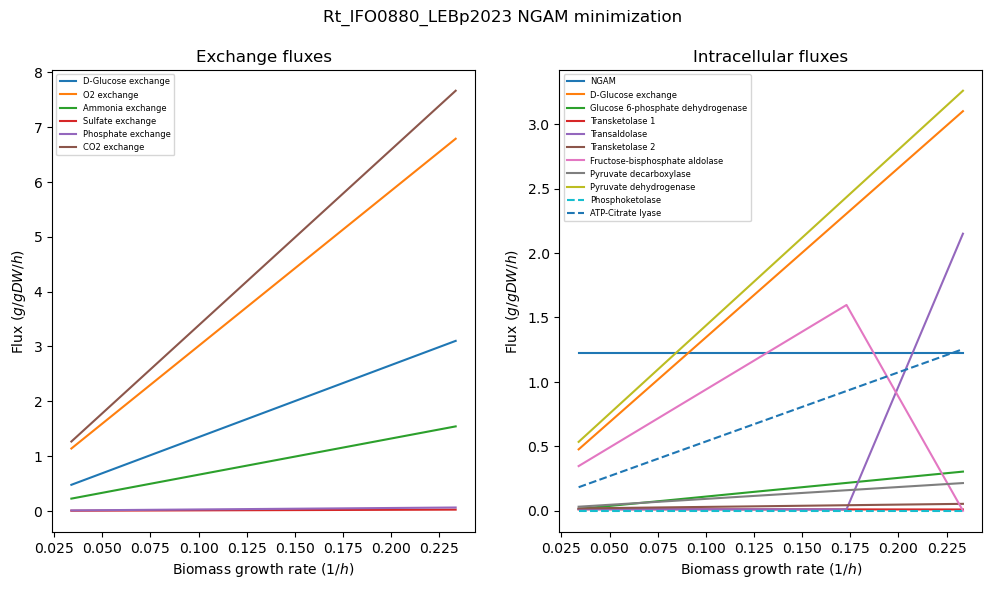

In [28]:
# Plot exchange and intracellular fluxes
fig, ax = plt.subplots(1, 2, figsize=(12,6)) #, 
fig.suptitle('Rt_IFO0880_LEBp2023 NGAM minimization')

# Sample data

x1 = all_fluxes_NGAM_min['BIOMASS_RT']
y1 = np.abs(exchange_fluxes_table)

ax[0].plot(x1, y1, '-', label= y1.columns) #
ax[0].legend(fontsize=6, loc='upper left')
ax[0].set_title("Exchange fluxes") #fluxes biomass maximization
ax[0].set_xlabel('Biomass growth rate $(1/h)$')
ax[0].set_ylabel('Flux $(g/gDW/h)$')

x2 = all_fluxes_NGAM_min['BIOMASS_RT']
y2 = np.abs(intracellular_fluxes.drop(columns = ['Phosphoketolase','ATP-Citrate lyase']))
y3 = np.abs(intracellular_fluxes[['Phosphoketolase','ATP-Citrate lyase']])

ax[1].plot(x2, y2, '-', label= y2.columns) #
ax[1].plot(x2, y3, '--', label= y3.columns) # ACL and phosphoketolase

ax[1].legend(fontsize=6, loc='upper left')
ax[1].set_title("Intracellular fluxes")
ax[1].set_xlabel('Biomass growth rate $(1/h)$')
ax[1].set_ylabel('Flux $(g/gDW/h)$')

For cofactor balances see Rt_IFO0880_jsb_cofactor_balances

In [29]:
# # Get all fluxes to excel
# with pd.ExcelWriter('C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\Rt_IFO0880_results\\all_fluxes_NGAM_min.xlsx') as excel_writer:
#     all_fluxes_dif_glucose_uptakes.to_excel(excel_writer, sheet_name='Glucose uptake range 0.49-3.1', index=True)

In [30]:
# # # #  Get csv files
# glucose_uptakes= [0.476, 1.114, 1.648, 2.305, 2.6619851, 3.1]
# i = 2
# all_fluxes_NGAM_min.loc[i].to_csv(f'C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\Rt_IFO0880_results\\fluxes_NGAM_min_glucose_uptake_{glucose_uptakes[i]}.csv', index=True)


# for i in range(len(glucose_uptakes)):
#     all_fluxes_dif_glucose_uptakes.loc[i].to_csv(f'C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\Rt_IFO0880_jsb_results\\SImulations_w_XPK_bounds\\all_fluxes_glucose_uptake_{glucose_uptakes[i]}.csv', index=True)